/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/201616-exported.nxs
EMAnalyser object created with 2623437 weighted events in range -661.5 - 661.5


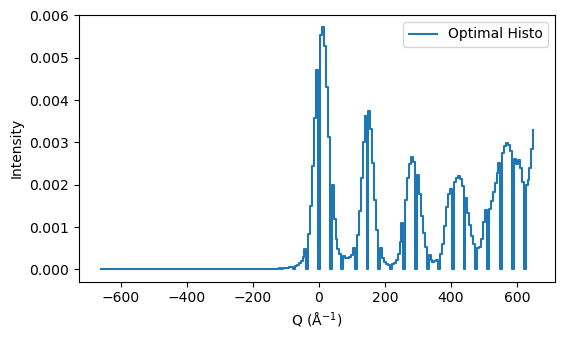

In [89]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import uniform


import emtk.EventModeAnalyser.EMAnalyser as ema

# During development, this lets us change the source and force reload
# However, whilst the error reporting line number is right, the printout of
# the offending source is stuck to the first import.  Just so you know...
import importlib
importlib.reload(ema) 

def loadRawARCS(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus"
    stem="/ARCS_"
    tail=".nxs.h5"

    filename = ldpath + stem + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')

    print( list(f.keys()) )

    entr = f['entry']
    b30 = entr['bank30_events']

    
    print( b30 )
    print( list(b30.keys()) )

    print(b30['event_id'])

    f.close()


def listkeys(obj):
    print( list( obj.keys()) )

def loadARCSmd(number):
    ldpath="/Users/phillipbentley/Code/python/mle/data/SNS/ARCS/ZrH2/IPTS-27751/nexus/"
    tail="-exported.nxs"

    filename = ldpath + str(number) + tail

    print(filename)

    f = h5py.File(filename, 'r')
    ws = f['MDEventWorkspace']
    cs = ws['coordinate_system']
    ed = ws['event_data']['event_data']
    bs = ws['box_structure']
    ex = ws['experiment0']
    pr = ws['process']
    vn = ws['visual_normalization']

    #for i in range(7):
    #    ed1 = ed[:,i]
    #    fig,ax = plt.subplots()
    #    plt.plot(ed1)

    dE = ed[:,6]
    wt = ed[:,0]

    #fig,ax = plt.subplots()
    #plt.plot(dE, wt)

    # Filter out zeros

    mask = wt > 0.0

    keepdE = dE[mask]
    keepwt = wt[mask]

    return keepdE, keepwt







""" We might need an integral function between two points (xmin, xmax) 
for every term in the fitting function, so that the relative likelihoods are 
normalised within the data bounds.  It will be good to check whether these
are actually needed or not in the final analysis, but in previous work
these proved to be necessary.
"""

def cauchy_integral(x1, x2, kappa):
    # Returns the integral of a cauchy distribution between two x values

    if x1 < x2:
        xmin = x1
        xmax = x2
    else:
        xmin = x2
        xmax = x1

    
    t1 = np.arctan(xmax/kappa)
    t2 = np.arctan(xmin/kappa)
    
    return (t1 - t2)/np.pi

    

def uniform_integral(x1, x2):
    # Returns the integral of a uniform distribution between two x values

    if(x1 == x2):
        return 0.0

    return np.absolute(x1-x2)



def gaussian_integral(x1, x2, mu=0.0, sigma=1.0):
    # Integral of a gaussian curve between two points
    t1 = norm.cdf(x1, loc=mu, scale=sigma)
    t2 = norm.cdf(x2, loc=mu, scale=sigma)
    intg = t1 - t2

    return np.absolute(intg)




evs, wts = loadARCSmd(201616)

ema1 = ema.EMAnalyser(evs, wts)

ema1.plot_histogram(loglog=False, log=False)



Least squares model function defined.


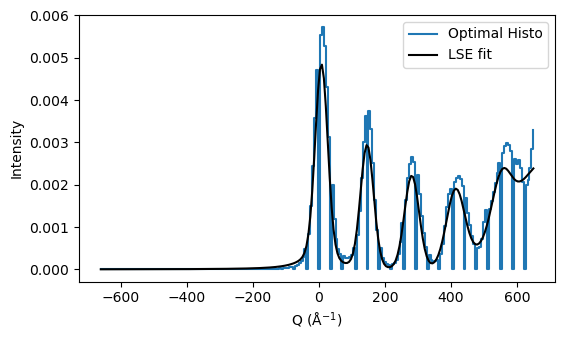

['amplitude', 'elmu', 'mu1', 'mu2', 'mu3', 'mu4', 'mubg1', 'mubg2', 'elsigma', 's1', 's2', 's3', 's4', 'sbg1', 'sbg2', 'm1', 'm2', 'm3', 'm4', 'mbg1', 'mbg2']
[1.03166976e+00 7.83319976e+00 1.45695047e+02 2.81254328e+02
 4.14035526e+02 5.52327378e+02 6.99999691e+02 2.30190791e-02
 1.86422670e+01 1.99165093e+01 2.21066916e+01 2.75136714e+01
 2.79613790e+01 1.16801601e+02 4.02817313e+01 1.90420268e-01
 1.40207127e-01 1.18191129e-01 1.18351136e-01 7.89817013e-02
 2.74781599e-01]
[4.61820689e-02 6.77407450e+00 2.42608681e+00 3.35152531e+00
 5.96478512e+00 1.22412580e+01 3.09337227e+02 3.62514381e+01
 3.89449285e+00 2.56288306e+00 3.38997008e+00 7.33200369e+00
 1.78787566e+01 5.13883390e+13 1.76492899e+02 2.18159185e-01
 1.82600064e-02 1.60267612e-02 4.38465615e-02 9.72543769e-02
 1.23466682e-01]


In [117]:
def big_lse_pdf(x, amplitude, elmu, mu1, mu2, mu3, mu4, mubg1, mubg2, elsigma, s1, s2, s3, s4, sbg1, sbg2, m1, m2, m3, m4, mbg1, mbg2):
    
    mvals = ema1.simplex_weights(np.array([m1, m2, m3, m4, mbg1, mbg2]))

    el = mvals[0] * norm.pdf(x, scale=elsigma, loc=elmu) / gaussian_integral(ema1.xmin, ema1.xmax, elsigma)

    l1 = mvals[1] * norm.pdf(x, scale=s1, loc=mu1) / gaussian_integral(ema1.xmin, ema1.xmax, mu1, s1)
    l2 = mvals[2] * norm.pdf(x, scale=s2, loc=mu2) / gaussian_integral(ema1.xmin, ema1.xmax, mu2, s2)
    l3 = mvals[3] * norm.pdf(x, scale=s3, loc=mu3) / gaussian_integral(ema1.xmin, ema1.xmax, mu3, s3)
    l4 = mvals[4] * norm.pdf(x, scale=s4, loc=mu4) / gaussian_integral(ema1.xmin, ema1.xmax, mu4, s4)
    bg1= mvals[5] * norm.pdf(x, scale=sbg1, loc=mubg1) / gaussian_integral(ema1.xmin, ema1.xmax, mubg1, sbg1)
    bg2= mvals[6] * cauchy.pdf(x, scale=sbg2, loc=mubg2) / cauchy_integral(ema1.xmin, ema1.xmax, sbg2)

    
    sol = amplitude * (el + l1 + l2 + l3 + l4 + bg1 + bg2)
    
    return sol


ema1.set_lse_function(big_lse_pdf)

ema1.make_lse_params(
    amplitude=dict(value=1.0, min=0.0),\
    elmu = dict(value=10.0, min=-100.0, max=100.0),\
    mu1 = dict(value=150.0, min=100.0, max=200.0),\
    mu2 = dict(value=280.0, min=200.0, max=350.0),\
    mu3 = dict(value=420.0, min=350.0, max=450.0),\
    mu4 = dict(value=560.0, min=500.0, max=620.0),\
    mubg1=dict(value=620.0, min=600.0, max=700.0),\
    mubg2=dict(value=140.0, min=0.0, max=200.0),\

    elsigma = dict(value=20.0, min=10.0, max=100.0),\
    s1 = dict(value=30.0, min=10.0, max=100.0),\
    s2 = dict(value=30.0, min=10.0, max=100.0),\
    s3 = dict(value=30.0, min=10.0, max=100.0),\
    s4 = dict(value=30.0, min=10.0, max=100.0),\
    sbg1=dict(value=100.0, min=100.0, max=250.0),\
    sbg2=dict(value=20.0, min=10.0, max=250.0),\
    m1=dict(value=0.3, min=0.0, max = 1.0),\
    m2=dict(value=0.2, min=0.0, max = 1.0),\
    m3=dict(value=0.15, min=0.0, max = 1.0),\
    m4=dict(value=0.1, min=0.0, max = 1.0),\
    mbg1=dict(value=0.1, min=0.0, max=1.0),\
    mbg2=dict(value=0.1, min=0.0, max=1.0)
)

#ema1.plot_LSE_initial(loglog=False, log=False)

ema1.lse_fit()
ema1.plot_LSE_fit(loglog=False, log=False)

pnams = ema1.get_lse_param_names()
print(pnams)

pvals = ema1.get_lse_param_values()
print(pvals)

psigs = ema1.get_lse_param_sigmas()
print(psigs)